<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Scripts

In [1]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
#Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')



In [3]:
# imports and constants
import json
import pickle
import datetime as dt

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import multiprocessing
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

# user imports
import data_processing.analysis_utils as ls_utils

%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

## Display Constants

In [4]:
agg_cols_change = ['active_apps_agg_change',
 'passive_apps_agg_change',
 'social_apps_agg_change',
 'work_dur_agg_change',
 'home_dur_agg_change',
 'religion_dur_agg_change',
 'exercise_dur_agg_change',                   
 'shopping_dur_agg_change',
 'other_dur_agg_change',
 'social_dur_agg_change',
 'sms_agg_change',
 'cal_agg_change',
 'movt_distance_agg_change',
 'movt_variance_agg_change',
 'movt_duration_agg_change']
sel_agg_cols = [x for x in agg_cols_change if 'fga' not in x]
groups = ['all', 'no/mild', 'symptomatic']

# Load Data

In [5]:
gad_spin_corr = pd.read_pickle("ls_data/jama_data/gad_spin_2grp.df")
rev_gad_spin_corr = pd.read_pickle("ls_data/jama_data/rev_gad_spin_2grp.df")

phq_corr = pd.read_pickle("ls_data/jama_data/phq_2grp.df")
rev_phq_corr = pd.read_pickle("ls_data/jama_data/rev_phq_2grp.df")

In [6]:
rev_gad_spin_corr['gad_diff'] = rev_gad_spin_corr['gad_diff'].astype(float)

# Feature Unit Weight Definitions

## Foreground Applications (fga)

- active apps: messaging, email, maps
- passive apps: chrome, youtube, browser
- social apps: orca, katana, instagram, snapchat

## Semantic Location (sloc)

- home duration: home_dur
- work duration: work_dur, education_dur
- religion duration: religion_dur
- exercise duration: exercise_dur
- shopping duration: shopping_dur, errands_dur
- social places: food_dur, anothers_home_dur, entertainment_dur
- other places: other_dur, health_dur, travel_dur

## Communication (comm)

- sms: in/out/tot_sms_count, in/out/tot_sms_length
- calls: tot_call_count, tot_call_duration

## Fused Location (fus)

- "movement distance": 'velocity_total', 'dist_total'
- "movement duration": 'entropy_total', 'norm_entropy_total', 'circ_movt_tot'
- "movement variance": 'cluster_total', 'loc_var_total'

# Plots Over Time

### PHQ

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


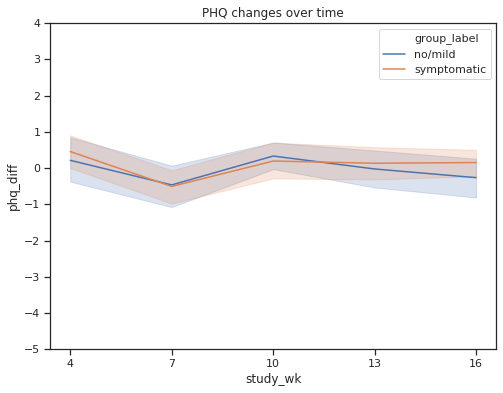

In [7]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="group_label", 
                 hue_order=['no/mild', 'symptomatic'],
                 data=phq_corr, ax=ax)
plt.xticks([4, 7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("PHQ changes over time")
plt.show()

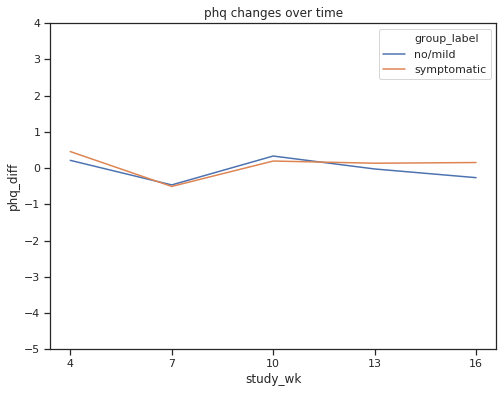

In [8]:
_, ax = plt.subplots(figsize=(8,6))
phq_corr['phq_start'] = pd.to_datetime(phq_corr['phq_start'])
g = sns.lineplot(x="study_wk", y="phq_diff", 
                 hue="group_label", 
                 hue_order=['no/mild', 'symptomatic'],
                 data=phq_corr, ax=ax,
                 ci=None)
plt.xticks([4,7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("phq changes over time")
plt.show()

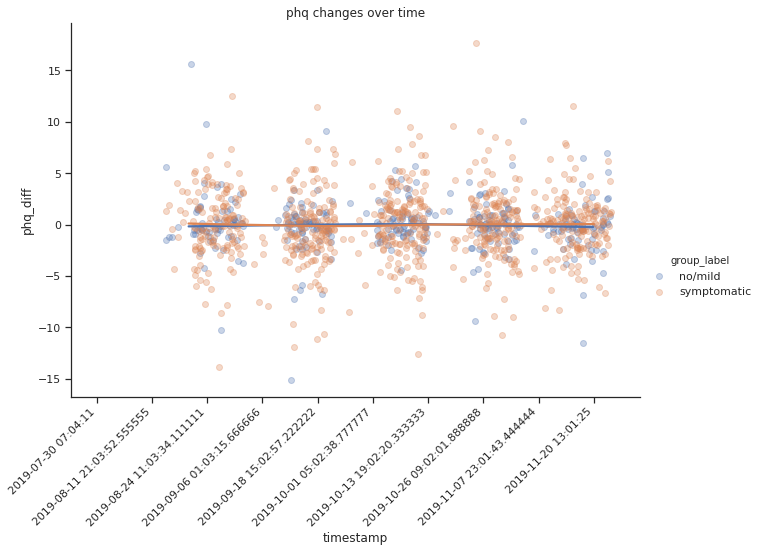

In [9]:
import matplotlib.dates as md

phq_corr['timestamp'] = (phq_corr['phq_start'] - dt.datetime(1970,1,1)).dt.total_seconds()


sns.lmplot(x='timestamp', y='phq_diff', 
           data=phq_corr, 
           lowess=True, 
           hue="group_label", 
           hue_order=['no/mild', 'symptomatic'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(phq_corr['timestamp'].min(), phq_corr['timestamp'].max(), 10)
idx = pd.date_range(phq_corr['phq_start'].min(), phq_corr['phq_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("phq changes over time")
plt.show()

In [10]:
group_dict = {k: v for k,v in zip(phq_corr['pid'], phq_corr['group_label'])}

In [11]:
phq_std = phq_corr.groupby('pid')['phq_diff'].std()
phq_std = phq_std.to_frame().reset_index()
phq_std = phq_std.rename(columns={'phq_diff': 'within person std'})
phq_std['group_label'] = phq_std['pid'].map(group_dict)

Text(0.5, 1.0, 'Within individual PHQ shift variance')

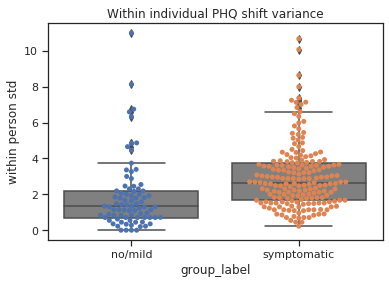

In [12]:
ax = sns.swarmplot(x="group_label", y='within person std', data=phq_std, order=['no/mild', 'symptomatic'])
ax = sns.boxplot(x="group_label", y='within person std', data=phq_std, color=".5", order=['no/mild', 'symptomatic'])
plt.title("Within individual PHQ shift variance")

In [13]:
phq_std.groupby('group_label').describe()

within person std                                          \
                        count      mean       std       min       25%   
group_label                                                             
no/mild                  82.0  1.883854  1.926726  0.000000  0.707107   
symptomatic             190.0  2.992173  1.799415  0.223607  1.673320   

                                            
                  50%       75%        max  
group_label                                 
no/mild      1.322741  2.190890  11.000000  
symptomatic  2.656947  3.733696  10.677078

### SPIN

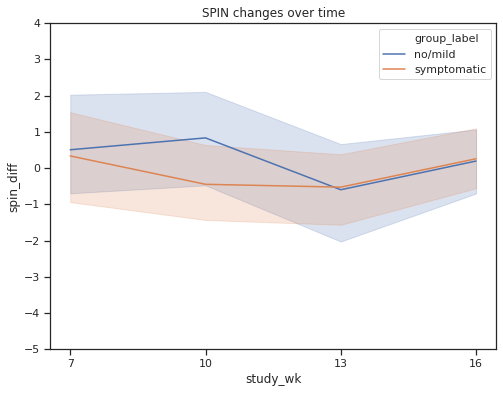

In [14]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="group_label", 
                 hue_order=['no/mild', 'symptomatic'],
                 data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

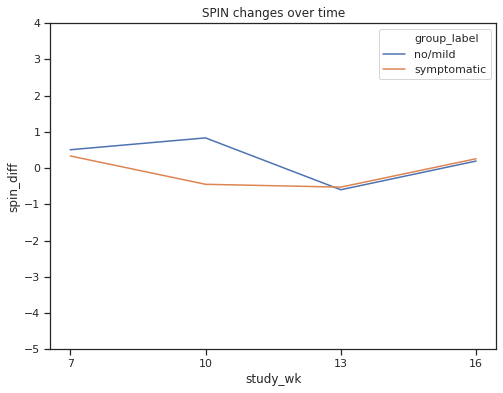

In [15]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['spin_start'] = pd.to_datetime(gad_spin_corr['spin_start'])
g = sns.lineplot(x="study_wk", y="spin_diff", 
                 hue="group_label", 
                 hue_order=['no/mild', 'symptomatic'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("SPIN changes over time")
plt.show()

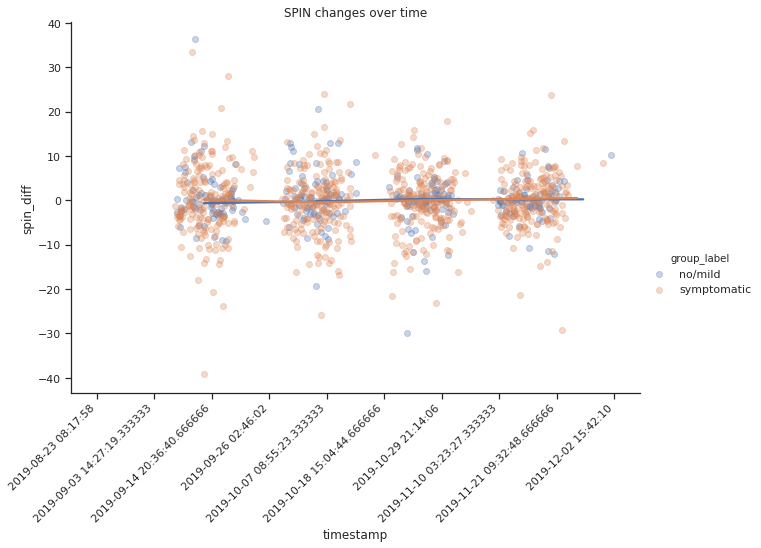

In [16]:
import matplotlib.dates as md

gad_spin_corr['timestamp'] = (gad_spin_corr['spin_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

sns.lmplot(x='timestamp', y='spin_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="group_label", 
           hue_order=['no/mild', 'symptomatic'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("SPIN changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual SPIN shift variance')

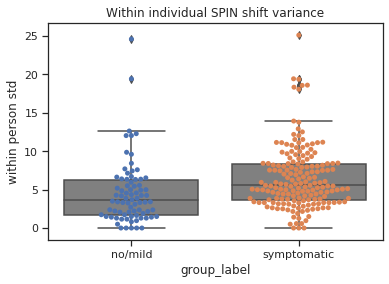

In [17]:
spin_std = gad_spin_corr.groupby('pid')['spin_diff'].std()
spin_std = spin_std.to_frame().reset_index()
spin_std['group_label'] = spin_std['pid'].map(group_dict)
spin_std = spin_std.rename(columns={'spin_diff': 'within person std'})


ax = sns.swarmplot(x="group_label", y='within person std', data=spin_std,
                   order=['no/mild', 'symptomatic'])
ax = sns.boxplot(x="group_label", y='within person std', data=spin_std, 
                 order=['no/mild', 'symptomatic'], 
                 color=".5")
plt.title("Within individual SPIN shift variance")

In [18]:
spin_std.describe()

,within person std
count,259.000000
mean,5.899790
std,4.163573
min,0.000000
25%,3.214132
50%,4.991660
75%,7.892507
max,25.118055


In [19]:
spin_std.groupby('group_label').describe()

within person std                                               \
                        count      mean       std  min       25%       50%   
group_label                                                                  
no/mild                  78.0  4.556241  4.167393  0.0  1.732051  3.592779   
symptomatic             179.0  6.506738  4.049654  0.0  3.685557  5.560276   

                                  
                  75%        max  
group_label                       
no/mild      6.234711  24.608603  
symptomatic  8.396422  25.118055

### GAD

In [20]:
gad_spin_corr['gad_diff'] = gad_spin_corr['gad_diff'].astype(float)

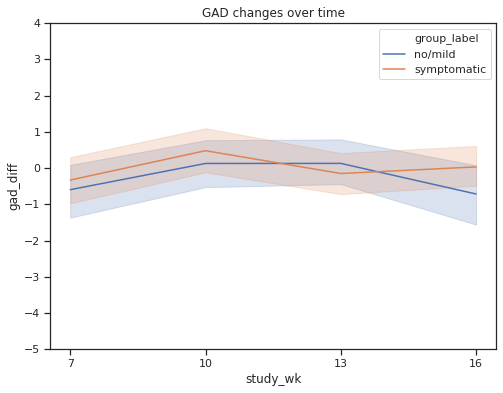

In [21]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="group_label", 
                 hue_order=['no/mild', 'symptomatic'],
                 data=gad_spin_corr, ax=ax)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

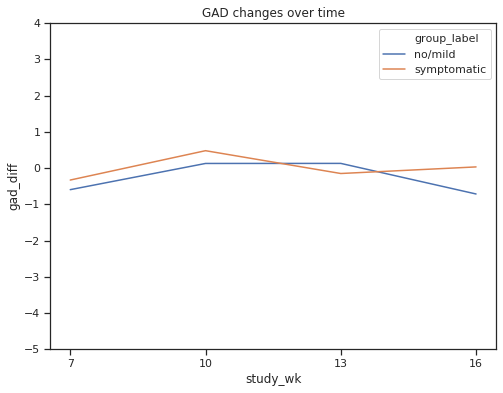

In [22]:
_, ax = plt.subplots(figsize=(8,6))
gad_spin_corr['gad_start'] = pd.to_datetime(gad_spin_corr['gad_start'])
g = sns.lineplot(x="study_wk", y="gad_diff", 
                 hue="group_label", 
                 hue_order=['no/mild', 'symptomatic'],
                 data=gad_spin_corr, ax=ax,
                 ci=None)
plt.xticks([7,10,13,16])
plt.ylim(-5,4)
plt.legend(loc="upper right")
plt.title("GAD changes over time")
plt.show()

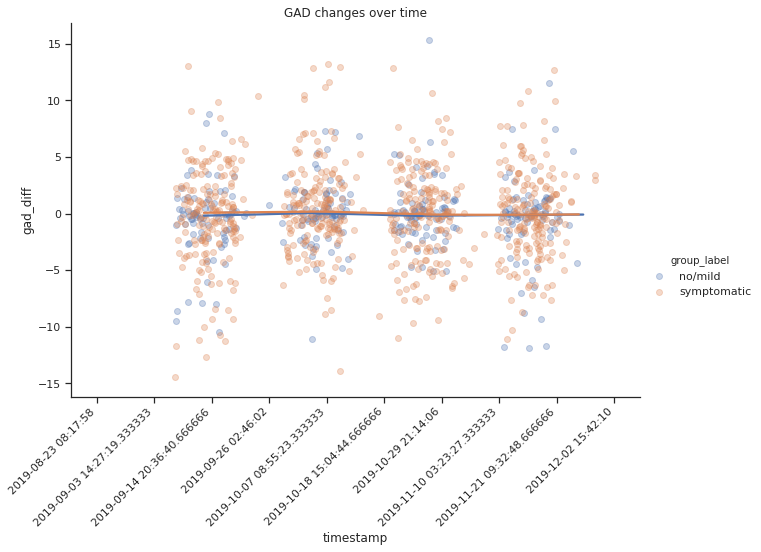

In [23]:
import matplotlib.dates as md

gad_spin_corr['timestamp'] = (gad_spin_corr['gad_start'] - dt.datetime(1970,1,1)).dt.total_seconds()

sns.lmplot(x='timestamp', y='gad_diff', 
           data=gad_spin_corr, 
           lowess=True, 
           hue="group_label", 
           hue_order=['no/mild', 'symptomatic'],
           x_jitter=500000, y_jitter=0.5,
           scatter_kws = {
               'alpha': 0.3
           },
           height=6,
           aspect=1.5
          )
ax=plt.gca()
ticks = np.linspace(gad_spin_corr['timestamp'].min(), gad_spin_corr['timestamp'].max(), 10)
idx = pd.date_range(gad_spin_corr['spin_start'].min(), gad_spin_corr['spin_start'].max(), 10).to_pydatetime()
plt.xticks(ticks, idx, rotation=45, ha='right')
#xfmt = md.DateFormatter('%Y-%m-%d')
#ax.xaxis.set_major_formatter(xfmt)
plt.title("GAD changes over time")
plt.show()

Text(0.5, 1.0, 'Within individual gad shift variance')

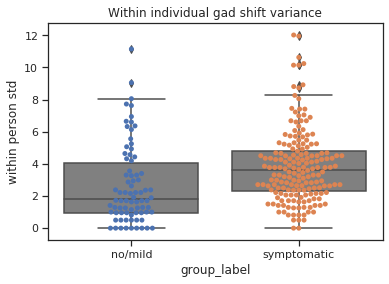

In [24]:
gad_std = gad_spin_corr.groupby('pid')['gad_diff'].std()
gad_std = gad_std.to_frame().reset_index()
gad_std['group_label'] = gad_std['pid'].map(group_dict)
gad_std = gad_std.rename(columns={'gad_diff': 'within person std'})


ax = sns.swarmplot(x="group_label", y='within person std', data=gad_std,
                   order=['no/mild', 'symptomatic'])
ax = sns.boxplot(x="group_label", y='within person std', data=gad_std, 
                 order=['no/mild', 'symptomatic'],
                 color=".5")
plt.title("Within individual gad shift variance")

In [25]:
gad_std.describe()

,within person std
count,260.000000
mean,3.501206
std,2.382952
min,0.000000
25%,1.707825
50%,3.054563
75%,4.654747
max,12.020815


In [26]:
gad_std.groupby('group_label').describe()

within person std                                              \
                        count      mean       std  min       25%      50%   
group_label                                                                 
no/mild                  78.0  2.686133  2.466545  0.0  0.957427  1.81251   
symptomatic             180.0  3.859190  2.275115  0.0  2.326520  3.62273   

                                  
                  75%        max  
group_label                       
no/mild      4.034693  11.150486  
symptomatic  4.827981  12.020815

# SPIN

## Full population

In [27]:
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1028,0.018,0.5654,0.8505,fdr_bh
1,passive_apps_agg_change,spin_diff,1028,0.043,0.1665,0.6244,fdr_bh
2,social_apps_agg_change,spin_diff,1028,-0.004,0.9010,0.9654,fdr_bh
3,work_dur_agg_change,spin_diff,1023,-0.001,0.9785,0.9785,fdr_bh
4,home_dur_agg_change,spin_diff,1023,0.018,0.5670,0.8505,fdr_bh
5,religion_dur_agg_change,spin_diff,1023,0.025,0.4195,0.7866,fdr_bh
6,exercise_dur_agg_change,spin_diff,1023,-0.013,0.6820,0.9300,fdr_bh
7,shopping_dur_agg_change,spin_diff,1023,-0.033,0.2910,0.6714,fdr_bh
8,other_dur_agg_change,spin_diff,1023,0.032,0.3061,0.6714,fdr_bh
9,social_dur_agg_change,spin_diff,1023,-0.076,0.0145*,0.2169,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1028,0.009,0.7828,0.8659,fdr_bh
1,passive_apps_agg_change,spin_diff,1028,0.078,0.0120*,0.1340,fdr_bh
2,social_apps_agg_change,spin_diff,1028,0.017,0.5801,0.7910,fdr_bh
3,work_dur_agg_change,spin_diff,1023,-0.021,0.4999,0.7910,fdr_bh
4,home_dur_agg_change,spin_diff,1023,0.01,0.7433,0.8659,fdr_bh
5,religion_dur_agg_change,spin_diff,1023,0.008,0.8081,0.8659,fdr_bh
6,exercise_dur_agg_change,spin_diff,1023,0.033,0.2859,0.7146,fdr_bh
7,shopping_dur_agg_change,spin_diff,1023,0.029,0.3557,0.7623,fdr_bh
8,other_dur_agg_change,spin_diff,1023,0.018,0.5700,0.7910,fdr_bh
9,social_dur_agg_change,spin_diff,1023,-0.052,0.0965*,0.3620,fdr_bh


## No/mild symptoms

In [28]:
sel_state_df = gad_spin_corr[gad_spin_corr['group_label'] == 'no/mild']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,310,0.088,0.1240,0.5121,fdr_bh
1,passive_apps_agg_change,spin_diff,310,0.084,0.1386,0.5121,fdr_bh
2,social_apps_agg_change,spin_diff,310,0.003,0.9539,0.9539,fdr_bh
3,work_dur_agg_change,spin_diff,310,-0.017,0.7697,0.9539,fdr_bh
4,home_dur_agg_change,spin_diff,310,-0.011,0.8487,0.9539,fdr_bh
5,religion_dur_agg_change,spin_diff,310,0.029,0.6072,0.9539,fdr_bh
6,exercise_dur_agg_change,spin_diff,310,-0.007,0.9089,0.9539,fdr_bh
7,shopping_dur_agg_change,spin_diff,310,-0.265,0.0000*,0.0000*,fdr_bh
8,other_dur_agg_change,spin_diff,310,0.064,0.2629,0.6572,fdr_bh
9,social_dur_agg_change,spin_diff,310,-0.086,0.1293,0.5121,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,310,0.085,0.1374,0.3642,fdr_bh
1,passive_apps_agg_change,spin_diff,310,0.109,0.0560*,0.2800,fdr_bh
2,social_apps_agg_change,spin_diff,310,0.038,0.5001,0.7663,fdr_bh
3,work_dur_agg_change,spin_diff,310,-0.037,0.5109,0.7663,fdr_bh
4,home_dur_agg_change,spin_diff,310,0.024,0.6734,0.8213,fdr_bh
5,religion_dur_agg_change,spin_diff,310,-0.041,0.4694,0.7663,fdr_bh
6,exercise_dur_agg_change,spin_diff,310,0.021,0.7118,0.8213,fdr_bh
7,shopping_dur_agg_change,spin_diff,310,0.006,0.9112,0.9112,fdr_bh
8,other_dur_agg_change,spin_diff,310,0.132,0.0203*,0.2800,fdr_bh
9,social_dur_agg_change,spin_diff,310,-0.111,0.0515*,0.2800,fdr_bh


## symptomatic

In [29]:
sel_state_df = gad_spin_corr[gad_spin_corr['group_label'] == 'symptomatic']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,718,-0.002,0.9500,0.9500,fdr_bh
1,passive_apps_agg_change,spin_diff,718,0.026,0.4868,0.9500,fdr_bh
2,social_apps_agg_change,spin_diff,718,-0.006,0.8684,0.9500,fdr_bh
3,work_dur_agg_change,spin_diff,713,0.003,0.9297,0.9500,fdr_bh
4,home_dur_agg_change,spin_diff,713,0.029,0.4370,0.9500,fdr_bh
5,religion_dur_agg_change,spin_diff,713,0.024,0.5239,0.9500,fdr_bh
6,exercise_dur_agg_change,spin_diff,713,-0.015,0.6919,0.9500,fdr_bh
7,shopping_dur_agg_change,spin_diff,713,0.085,0.0233*,0.3491,fdr_bh
8,other_dur_agg_change,spin_diff,713,0.014,0.7045,0.9500,fdr_bh
9,social_dur_agg_change,spin_diff,713,-0.073,0.0512*,0.3844,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,718,-0.022,0.5560,0.8671,fdr_bh
1,passive_apps_agg_change,spin_diff,718,0.07,0.0619*,0.3523,fdr_bh
2,social_apps_agg_change,spin_diff,718,0.009,0.8093,0.8671,fdr_bh
3,work_dur_agg_change,spin_diff,713,-0.018,0.6254,0.8671,fdr_bh
4,home_dur_agg_change,spin_diff,713,0.01,0.7813,0.8671,fdr_bh
5,religion_dur_agg_change,spin_diff,713,0.03,0.4218,0.8671,fdr_bh
6,exercise_dur_agg_change,spin_diff,713,0.044,0.2446,0.7339,fdr_bh
7,shopping_dur_agg_change,spin_diff,713,0.045,0.2314,0.7339,fdr_bh
8,other_dur_agg_change,spin_diff,713,-0.021,0.5725,0.8671,fdr_bh
9,social_dur_agg_change,spin_diff,713,-0.037,0.3236,0.8090,fdr_bh


# Reverse SPIN

## Full population

In [30]:
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1023,0.037,0.2344,0.5133,fdr_bh
1,passive_apps_agg_change,spin_diff,1023,-0.008,0.7957,0.9149,fdr_bh
2,social_apps_agg_change,spin_diff,1023,0.025,0.4259,0.7098,fdr_bh
3,work_dur_agg_change,spin_diff,1020,0.009,0.7707,0.9149,fdr_bh
4,home_dur_agg_change,spin_diff,1020,0.033,0.2948,0.5527,fdr_bh
5,religion_dur_agg_change,spin_diff,1020,0.052,0.0973*,0.3650,fdr_bh
6,exercise_dur_agg_change,spin_diff,1020,-0.059,0.0581*,0.3650,fdr_bh
7,shopping_dur_agg_change,spin_diff,1020,0.013,0.6899,0.9149,fdr_bh
8,other_dur_agg_change,spin_diff,1020,0.003,0.9149,0.9149,fdr_bh
9,social_dur_agg_change,spin_diff,1020,0.046,0.1451,0.4352,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,1023,0.024,0.4347,0.7245,fdr_bh
1,passive_apps_agg_change,spin_diff,1023,0.007,0.8229,0.9211,fdr_bh
2,social_apps_agg_change,spin_diff,1023,0.046,0.1448,0.7238,fdr_bh
3,work_dur_agg_change,spin_diff,1020,0.029,0.3498,0.7245,fdr_bh
4,home_dur_agg_change,spin_diff,1020,0.033,0.2939,0.7245,fdr_bh
5,religion_dur_agg_change,spin_diff,1020,0.019,0.5438,0.7793,fdr_bh
6,exercise_dur_agg_change,spin_diff,1020,-0.018,0.5715,0.7793,fdr_bh
7,shopping_dur_agg_change,spin_diff,1020,-0.004,0.9002,0.9211,fdr_bh
8,other_dur_agg_change,spin_diff,1020,0.059,0.0585*,0.4384,fdr_bh
9,social_dur_agg_change,spin_diff,1020,0.036,0.2469,0.7245,fdr_bh


## no/mild

In [31]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['group_label'] == 'no/mild']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,309,0.009,0.8780,0.9462,fdr_bh
1,passive_apps_agg_change,spin_diff,309,0.011,0.8450,0.9462,fdr_bh
2,social_apps_agg_change,spin_diff,309,0.009,0.8687,0.9462,fdr_bh
3,work_dur_agg_change,spin_diff,309,0.053,0.3522,0.9462,fdr_bh
4,home_dur_agg_change,spin_diff,309,0.009,0.8743,0.9462,fdr_bh
5,religion_dur_agg_change,spin_diff,309,0.07,0.2189,0.9462,fdr_bh
6,exercise_dur_agg_change,spin_diff,309,-0.054,0.3416,0.9462,fdr_bh
7,shopping_dur_agg_change,spin_diff,309,0.119,0.0361*,0.5408,fdr_bh
8,other_dur_agg_change,spin_diff,309,0.007,0.8965,0.9462,fdr_bh
9,social_dur_agg_change,spin_diff,309,0.098,0.0856*,0.6417,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,309,-0.034,0.5569,0.8913,fdr_bh
1,passive_apps_agg_change,spin_diff,309,0.012,0.8319,0.8913,fdr_bh
2,social_apps_agg_change,spin_diff,309,0.081,0.1545,0.4636,fdr_bh
3,work_dur_agg_change,spin_diff,309,0.047,0.4134,0.7881,fdr_bh
4,home_dur_agg_change,spin_diff,309,0.046,0.4203,0.7881,fdr_bh
5,religion_dur_agg_change,spin_diff,309,0.088,0.1245,0.4636,fdr_bh
6,exercise_dur_agg_change,spin_diff,309,0,0.9960,0.9960,fdr_bh
7,shopping_dur_agg_change,spin_diff,309,0.013,0.8200,0.8913,fdr_bh
8,other_dur_agg_change,spin_diff,309,-0.017,0.7711,0.8913,fdr_bh
9,social_dur_agg_change,spin_diff,309,0.125,0.0285*,0.3486,fdr_bh


## symptomatic

In [32]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['group_label'] == 'symptomatic']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'spin_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,714,0.047,0.2118,0.6355,fdr_bh
1,passive_apps_agg_change,spin_diff,714,-0.02,0.5979,0.8264,fdr_bh
2,social_apps_agg_change,spin_diff,714,0.032,0.3936,0.6559,fdr_bh
3,work_dur_agg_change,spin_diff,711,-0.003,0.9366,0.9517,fdr_bh
4,home_dur_agg_change,spin_diff,711,0.042,0.2629,0.6559,fdr_bh
5,religion_dur_agg_change,spin_diff,711,0.048,0.2015,0.6355,fdr_bh
6,exercise_dur_agg_change,spin_diff,711,-0.062,0.0972*,0.4861,fdr_bh
7,shopping_dur_agg_change,spin_diff,711,-0.033,0.3772,0.6559,fdr_bh
8,other_dur_agg_change,spin_diff,711,0.002,0.9517,0.9517,fdr_bh
9,social_dur_agg_change,spin_diff,711,0.019,0.6060,0.8264,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,spin_diff,714,0.052,0.1621,0.8107,fdr_bh
1,passive_apps_agg_change,spin_diff,714,0.007,0.8539,0.8963,fdr_bh
2,social_apps_agg_change,spin_diff,714,0.039,0.3027,0.8963,fdr_bh
3,work_dur_agg_change,spin_diff,711,0.024,0.5162,0.8963,fdr_bh
4,home_dur_agg_change,spin_diff,711,0.03,0.4312,0.8963,fdr_bh
5,religion_dur_agg_change,spin_diff,711,-0.015,0.6982,0.8963,fdr_bh
6,exercise_dur_agg_change,spin_diff,711,-0.025,0.4986,0.8963,fdr_bh
7,shopping_dur_agg_change,spin_diff,711,-0.01,0.7827,0.8963,fdr_bh
8,other_dur_agg_change,spin_diff,711,0.084,0.0253*,0.1898,fdr_bh
9,social_dur_agg_change,spin_diff,711,-0.005,0.8963,0.8963,fdr_bh


# GAD

## Full population

In [33]:
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1029,0.044,0.1581,0.4742,fdr_bh
1,passive_apps_agg_change,gad_diff,1029,0.026,0.4133,0.6888,fdr_bh
2,social_apps_agg_change,gad_diff,1029,-0.033,0.2838,0.5320,fdr_bh
3,work_dur_agg_change,gad_diff,1024,0.049,0.1143,0.4742,fdr_bh
4,home_dur_agg_change,gad_diff,1024,0.011,0.7366,0.7366,fdr_bh
5,religion_dur_agg_change,gad_diff,1024,0.013,0.6821,0.7366,fdr_bh
6,exercise_dur_agg_change,gad_diff,1024,0.014,0.6567,0.7366,fdr_bh
7,shopping_dur_agg_change,gad_diff,1024,-0.034,0.2795,0.5320,fdr_bh
8,other_dur_agg_change,gad_diff,1024,-0.044,0.1579,0.4742,fdr_bh
9,social_dur_agg_change,gad_diff,1024,-0.034,0.2710,0.5320,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1029,0.083,0.0079*,0.0720*,fdr_bh
1,passive_apps_agg_change,gad_diff,1029,0.023,0.4578,0.8619,fdr_bh
2,social_apps_agg_change,gad_diff,1029,-0.028,0.3621,0.8619,fdr_bh
3,work_dur_agg_change,gad_diff,1024,0.07,0.0249*,0.0935*,fdr_bh
4,home_dur_agg_change,gad_diff,1024,-0.002,0.9427,0.9469,fdr_bh
5,religion_dur_agg_change,gad_diff,1024,-0.004,0.8886,0.9469,fdr_bh
6,exercise_dur_agg_change,gad_diff,1024,0.017,0.5868,0.8619,fdr_bh
7,shopping_dur_agg_change,gad_diff,1024,-0.004,0.8955,0.9469,fdr_bh
8,other_dur_agg_change,gad_diff,1024,-0.015,0.6320,0.8619,fdr_bh
9,social_dur_agg_change,gad_diff,1024,-0.022,0.4731,0.8619,fdr_bh


## no/mild

In [34]:
sel_state_df = gad_spin_corr[gad_spin_corr['group_label'] == 'no/mild']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,310,-0.077,0.1761,0.4713,fdr_bh
1,passive_apps_agg_change,gad_diff,310,0.044,0.4443,0.6059,fdr_bh
2,social_apps_agg_change,gad_diff,310,0.079,0.1655,0.4713,fdr_bh
3,work_dur_agg_change,gad_diff,310,0.058,0.3058,0.4713,fdr_bh
4,home_dur_agg_change,gad_diff,310,0.076,0.1808,0.4713,fdr_bh
5,religion_dur_agg_change,gad_diff,310,0.024,0.6799,0.7748,fdr_bh
6,exercise_dur_agg_change,gad_diff,310,0.02,0.7231,0.7748,fdr_bh
7,shopping_dur_agg_change,gad_diff,310,-0.084,0.1408,0.4713,fdr_bh
8,other_dur_agg_change,gad_diff,310,-0.069,0.2276,0.4713,fdr_bh
9,social_dur_agg_change,gad_diff,310,-0.06,0.2928,0.4713,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,310,-0.014,0.8017,0.9862,fdr_bh
1,passive_apps_agg_change,gad_diff,310,0.147,0.0096*,0.1437,fdr_bh
2,social_apps_agg_change,gad_diff,310,0.057,0.3137,0.9410,fdr_bh
3,work_dur_agg_change,gad_diff,310,-0.025,0.6554,0.9862,fdr_bh
4,home_dur_agg_change,gad_diff,310,0.016,0.7781,0.9862,fdr_bh
5,religion_dur_agg_change,gad_diff,310,-0.002,0.9657,0.9862,fdr_bh
6,exercise_dur_agg_change,gad_diff,310,0.001,0.9862,0.9862,fdr_bh
7,shopping_dur_agg_change,gad_diff,310,-0.074,0.1928,0.9410,fdr_bh
8,other_dur_agg_change,gad_diff,310,0.017,0.7637,0.9862,fdr_bh
9,social_dur_agg_change,gad_diff,310,0.006,0.9217,0.9862,fdr_bh


## symptomatic

In [35]:
sel_state_df = gad_spin_corr[gad_spin_corr['group_label'] == 'symptomatic']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,719,0.08,0.0322*,0.2565,fdr_bh
1,passive_apps_agg_change,gad_diff,719,0.017,0.6451,0.8187,fdr_bh
2,social_apps_agg_change,gad_diff,719,-0.079,0.0342*,0.2565,fdr_bh
3,work_dur_agg_change,gad_diff,714,0.047,0.2129,0.6370,fdr_bh
4,home_dur_agg_change,gad_diff,714,-0.014,0.6996,0.8187,fdr_bh
5,religion_dur_agg_change,gad_diff,714,0.009,0.8039,0.8187,fdr_bh
6,exercise_dur_agg_change,gad_diff,714,0.01,0.7944,0.8187,fdr_bh
7,shopping_dur_agg_change,gad_diff,714,-0.009,0.8187,0.8187,fdr_bh
8,other_dur_agg_change,gad_diff,714,-0.034,0.3712,0.7955,fdr_bh
9,social_dur_agg_change,gad_diff,714,-0.027,0.4715,0.8187,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,719,0.12,0.0013*,0.0194*,fdr_bh
1,passive_apps_agg_change,gad_diff,719,-0.014,0.7002,0.8752,fdr_bh
2,social_apps_agg_change,gad_diff,719,-0.059,0.1159,0.3478,fdr_bh
3,work_dur_agg_change,gad_diff,714,0.098,0.0087*,0.0654*,fdr_bh
4,home_dur_agg_change,gad_diff,714,-0.008,0.8337,0.8933,fdr_bh
5,religion_dur_agg_change,gad_diff,714,-0.01,0.7804,0.8933,fdr_bh
6,exercise_dur_agg_change,gad_diff,714,0.017,0.6446,0.8752,fdr_bh
7,shopping_dur_agg_change,gad_diff,714,0.023,0.5419,0.8128,fdr_bh
8,other_dur_agg_change,gad_diff,714,-0.027,0.4794,0.7990,fdr_bh
9,social_dur_agg_change,gad_diff,714,-0.033,0.3750,0.7990,fdr_bh


# Reverse GAD

## Full population

In [36]:
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_gad_spin_corr, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1023,0.023,0.4716,0.6506,fdr_bh
1,passive_apps_agg_change,gad_diff,1023,-0.003,0.9296,0.9296,fdr_bh
2,social_apps_agg_change,gad_diff,1023,0.07,0.0242*,0.2334,fdr_bh
3,work_dur_agg_change,gad_diff,1020,-0.008,0.7863,0.8425,fdr_bh
4,home_dur_agg_change,gad_diff,1020,-0.038,0.2271,0.5113,fdr_bh
5,religion_dur_agg_change,gad_diff,1020,0.01,0.7449,0.8425,fdr_bh
6,exercise_dur_agg_change,gad_diff,1020,-0.034,0.2727,0.5113,fdr_bh
7,shopping_dur_agg_change,gad_diff,1020,-0.022,0.4771,0.6506,fdr_bh
8,other_dur_agg_change,gad_diff,1020,0.035,0.2583,0.5113,fdr_bh
9,social_dur_agg_change,gad_diff,1020,0.043,0.1665,0.4994,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,1023,0.022,0.4827,0.6562,fdr_bh
1,passive_apps_agg_change,gad_diff,1023,-0.029,0.3555,0.6467,fdr_bh
2,social_apps_agg_change,gad_diff,1023,0.059,0.0590*,0.3836,fdr_bh
3,work_dur_agg_change,gad_diff,1020,-0.027,0.3880,0.6467,fdr_bh
4,home_dur_agg_change,gad_diff,1020,-0.041,0.1902,0.5707,fdr_bh
5,religion_dur_agg_change,gad_diff,1020,-0.043,0.1733,0.5707,fdr_bh
6,exercise_dur_agg_change,gad_diff,1020,-0.019,0.5493,0.6562,fdr_bh
7,shopping_dur_agg_change,gad_diff,1020,0.001,0.9671,0.9671,fdr_bh
8,other_dur_agg_change,gad_diff,1020,0.036,0.2468,0.6171,fdr_bh
9,social_dur_agg_change,gad_diff,1020,0.056,0.0728*,0.3836,fdr_bh


## no/mild

In [37]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['group_label'] == 'no/mild']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,309,0.053,0.3491,0.5914,fdr_bh
1,passive_apps_agg_change,gad_diff,309,-0.032,0.5799,0.6691,fdr_bh
2,social_apps_agg_change,gad_diff,309,0.032,0.5788,0.6691,fdr_bh
3,work_dur_agg_change,gad_diff,309,0.112,0.0496*,0.2480,fdr_bh
4,home_dur_agg_change,gad_diff,309,-0.034,0.5494,0.6691,fdr_bh
5,religion_dur_agg_change,gad_diff,309,-0.015,0.7996,0.7996,fdr_bh
6,exercise_dur_agg_change,gad_diff,309,0.017,0.7627,0.7996,fdr_bh
7,shopping_dur_agg_change,gad_diff,309,-0.059,0.2997,0.5914,fdr_bh
8,other_dur_agg_change,gad_diff,309,0.116,0.0417*,0.2480,fdr_bh
9,social_dur_agg_change,gad_diff,309,0.069,0.2254,0.5635,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,309,0.065,0.2526,0.6417,fdr_bh
1,passive_apps_agg_change,gad_diff,309,-0.101,0.0753*,0.5647,fdr_bh
2,social_apps_agg_change,gad_diff,309,0.034,0.5469,0.7762,fdr_bh
3,work_dur_agg_change,gad_diff,309,0.024,0.6727,0.7762,fdr_bh
4,home_dur_agg_change,gad_diff,309,-0.064,0.2604,0.6417,fdr_bh
5,religion_dur_agg_change,gad_diff,309,0.026,0.6447,0.7762,fdr_bh
6,exercise_dur_agg_change,gad_diff,309,-0.005,0.9344,0.9344,fdr_bh
7,shopping_dur_agg_change,gad_diff,309,-0.059,0.2995,0.6417,fdr_bh
8,other_dur_agg_change,gad_diff,309,0.09,0.1137,0.5684,fdr_bh
9,social_dur_agg_change,gad_diff,309,0.066,0.2497,0.6417,fdr_bh


## symptomatic

In [38]:
rev_sel_state_df = rev_gad_spin_corr[rev_gad_spin_corr['group_label'] == 'symptomatic']
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='pearson')
ls_utils.display_all_corr(rev_sel_state_df, agg_cols_change, 'gad_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,714,0.012,0.7498,0.9373,fdr_bh
1,passive_apps_agg_change,gad_diff,714,0.014,0.7183,0.9373,fdr_bh
2,social_apps_agg_change,gad_diff,714,0.086,0.0212*,0.3174,fdr_bh
3,work_dur_agg_change,gad_diff,711,-0.043,0.2538,0.6346,fdr_bh
4,home_dur_agg_change,gad_diff,711,-0.039,0.2968,0.6359,fdr_bh
5,religion_dur_agg_change,gad_diff,711,0.016,0.6784,0.9373,fdr_bh
6,exercise_dur_agg_change,gad_diff,711,-0.058,0.1244,0.4667,fdr_bh
7,shopping_dur_agg_change,gad_diff,711,-0.007,0.8552,0.9867,fdr_bh
8,other_dur_agg_change,gad_diff,711,0.001,0.9882,0.9882,fdr_bh
9,social_dur_agg_change,gad_diff,711,0.035,0.3565,0.6684,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,gad_diff,714,0.005,0.8903,0.9118,fdr_bh
1,passive_apps_agg_change,gad_diff,714,-0.004,0.9118,0.9118,fdr_bh
2,social_apps_agg_change,gad_diff,714,0.063,0.0901*,0.4814,fdr_bh
3,work_dur_agg_change,gad_diff,711,-0.045,0.2352,0.6881,fdr_bh
4,home_dur_agg_change,gad_diff,711,-0.032,0.3903,0.6881,fdr_bh
5,religion_dur_agg_change,gad_diff,711,-0.076,0.0423*,0.4814,fdr_bh
6,exercise_dur_agg_change,gad_diff,711,-0.024,0.5161,0.6881,fdr_bh
7,shopping_dur_agg_change,gad_diff,711,0.025,0.5070,0.6881,fdr_bh
8,other_dur_agg_change,gad_diff,711,0.022,0.5505,0.6881,fdr_bh
9,social_dur_agg_change,gad_diff,711,0.05,0.1829,0.6858,fdr_bh


# PHQ

## Entire population

In [39]:
ls_utils.display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(phq_corr, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.042,0.1670,0.2783,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,0.03,0.3253,0.4067,fdr_bh
2,social_apps_agg_change,phq_diff,1079,0.065,0.0321*,0.0801*,fdr_bh
3,work_dur_agg_change,phq_diff,1078,0.016,0.5889,0.6309,fdr_bh
4,home_dur_agg_change,phq_diff,1078,0.061,0.0470*,0.1006,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.039,0.1955,0.2932,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,0.111,0.0003*,0.0010*,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,-0.001,0.9750,0.9750,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.054,0.0765*,0.1434,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.068,0.0250*,0.0750*,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.042,0.1638,0.2730,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,0.034,0.2613,0.3266,fdr_bh
2,social_apps_agg_change,phq_diff,1079,0.075,0.0141*,0.0422*,fdr_bh
3,work_dur_agg_change,phq_diff,1078,-0.016,0.5990,0.6418,fdr_bh
4,home_dur_agg_change,phq_diff,1078,0.071,0.0198*,0.0494*,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.039,0.1953,0.2929,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,0.078,0.0108*,0.0405*,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,-0.01,0.7448,0.7448,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.059,0.0509*,0.0954*,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.037,0.2259,0.3080,fdr_bh


## no/mild

In [40]:
sel_state_df = phq_corr[phq_corr['group_label'] == 'no/mild']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,325,-0.105,0.0577*,0.2163,fdr_bh
1,passive_apps_agg_change,phq_diff,325,-0.001,0.9839,0.9946,fdr_bh
2,social_apps_agg_change,phq_diff,325,0.023,0.6836,0.9322,fdr_bh
3,work_dur_agg_change,phq_diff,325,0.035,0.5238,0.7857,fdr_bh
4,home_dur_agg_change,phq_diff,325,-0.037,0.5044,0.7857,fdr_bh
5,religion_dur_agg_change,phq_diff,325,-0.114,0.0398*,0.1992,fdr_bh
6,exercise_dur_agg_change,phq_diff,325,0.017,0.7668,0.9584,fdr_bh
7,shopping_dur_agg_change,phq_diff,325,-0.043,0.4431,0.7857,fdr_bh
8,other_dur_agg_change,phq_diff,325,-0.008,0.8863,0.9946,fdr_bh
9,social_dur_agg_change,phq_diff,325,-0.071,0.2022,0.4332,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,325,-0.089,0.1077,0.5683,fdr_bh
1,passive_apps_agg_change,phq_diff,325,-0.02,0.7195,0.9384,fdr_bh
2,social_apps_agg_change,phq_diff,325,0.013,0.8167,0.9384,fdr_bh
3,work_dur_agg_change,phq_diff,325,-0.045,0.4237,0.8226,fdr_bh
4,home_dur_agg_change,phq_diff,325,0.012,0.8248,0.9384,fdr_bh
5,religion_dur_agg_change,phq_diff,325,-0.004,0.9384,0.9384,fdr_bh
6,exercise_dur_agg_change,phq_diff,325,-0.033,0.5484,0.8226,fdr_bh
7,shopping_dur_agg_change,phq_diff,325,-0.049,0.3750,0.8226,fdr_bh
8,other_dur_agg_change,phq_diff,325,-0.088,0.1137,0.5683,fdr_bh
9,social_dur_agg_change,phq_diff,325,-0.038,0.4937,0.8226,fdr_bh


## symptomatic

In [41]:
sel_state_df = phq_corr[phq_corr['group_label'] == 'symptomatic']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,754,-0.023,0.5267,0.6951,fdr_bh
1,passive_apps_agg_change,phq_diff,754,0.045,0.2194,0.3657,fdr_bh
2,social_apps_agg_change,phq_diff,754,0.08,0.0284*,0.0608*,fdr_bh
3,work_dur_agg_change,phq_diff,753,0.01,0.7768,0.8323,fdr_bh
4,home_dur_agg_change,phq_diff,753,0.094,0.0097*,0.0291*,fdr_bh
5,religion_dur_agg_change,phq_diff,753,-0.014,0.6985,0.8059,fdr_bh
6,exercise_dur_agg_change,phq_diff,753,0.153,0.0000*,0.0002*,fdr_bh
7,shopping_dur_agg_change,phq_diff,753,0.022,0.5429,0.6951,fdr_bh
8,other_dur_agg_change,phq_diff,753,-0.091,0.0130*,0.0324*,fdr_bh
9,social_dur_agg_change,phq_diff,753,-0.069,0.0596*,0.1117,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,754,-0.027,0.4605,0.5313,fdr_bh
1,passive_apps_agg_change,phq_diff,754,0.053,0.1469,0.2748,fdr_bh
2,social_apps_agg_change,phq_diff,754,0.091,0.0127*,0.0318*,fdr_bh
3,work_dur_agg_change,phq_diff,753,-0.009,0.8024,0.8597,fdr_bh
4,home_dur_agg_change,phq_diff,753,0.094,0.0098*,0.0293*,fdr_bh
5,religion_dur_agg_change,phq_diff,753,-0.049,0.1832,0.2748,fdr_bh
6,exercise_dur_agg_change,phq_diff,753,0.13,0.0003*,0.0017*,fdr_bh
7,shopping_dur_agg_change,phq_diff,753,0.003,0.9332,0.9332,fdr_bh
8,other_dur_agg_change,phq_diff,753,-0.049,0.1753,0.2748,fdr_bh
9,social_dur_agg_change,phq_diff,753,-0.035,0.3380,0.4608,fdr_bh


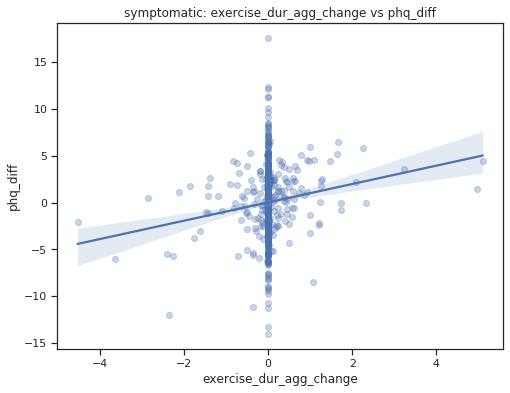

In [42]:
ls_utils.plot_cluster_scatter('exercise_dur_agg_change', 'phq_diff', phq_corr, 'symptomatic', (8,6), cluster_col='group_label')

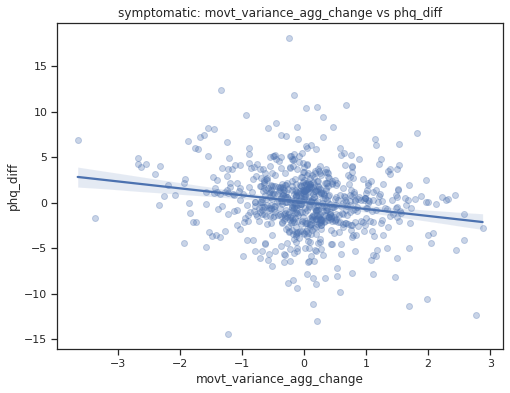

In [43]:
ls_utils.plot_cluster_scatter('movt_variance_agg_change', 'phq_diff', phq_corr, 'symptomatic', (8,6), cluster_col='group_label')

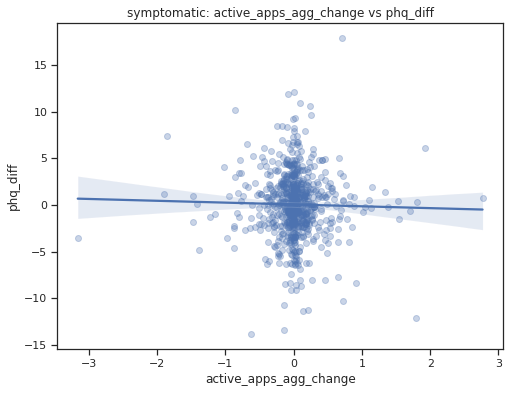

In [44]:
ls_utils.plot_cluster_scatter('active_apps_agg_change', 'phq_diff', phq_corr, 'symptomatic', (8,6), cluster_col='group_label')

# Reverse PHQ

## Full population

In [45]:
ls_utils.display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(rev_phq_corr, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.001,0.9632,0.9632,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,-0.059,0.0524*,0.1975,fdr_bh
2,social_apps_agg_change,phq_diff,1079,-0.018,0.5611,0.8979,fdr_bh
3,work_dur_agg_change,phq_diff,1078,-0.016,0.5986,0.8979,fdr_bh
4,home_dur_agg_change,phq_diff,1078,0.021,0.4958,0.8979,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.078,0.0101*,0.1519,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,-0.069,0.0228*,0.1707,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,-0.011,0.7254,0.9068,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.033,0.2757,0.8272,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.027,0.3696,0.8979,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,1079,-0.003,0.9311,0.9633,fdr_bh
1,passive_apps_agg_change,phq_diff,1079,-0.043,0.1559,0.9633,fdr_bh
2,social_apps_agg_change,phq_diff,1079,-0.015,0.6267,0.9633,fdr_bh
3,work_dur_agg_change,phq_diff,1078,-0.024,0.4272,0.9633,fdr_bh
4,home_dur_agg_change,phq_diff,1078,-0.006,0.8505,0.9633,fdr_bh
5,religion_dur_agg_change,phq_diff,1078,-0.062,0.0429*,0.6431,fdr_bh
6,exercise_dur_agg_change,phq_diff,1078,-0.008,0.7879,0.9633,fdr_bh
7,shopping_dur_agg_change,phq_diff,1078,0.015,0.6164,0.9633,fdr_bh
8,other_dur_agg_change,phq_diff,1078,-0.008,0.7988,0.9633,fdr_bh
9,social_dur_agg_change,phq_diff,1078,-0.031,0.3052,0.9633,fdr_bh


## no/mild

In [46]:
sel_state_df = rev_phq_corr[rev_phq_corr['group_label'] == 'no/mild']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,325,-0.079,0.1558,0.4429,fdr_bh
1,passive_apps_agg_change,phq_diff,325,-0.007,0.9047,0.9192,fdr_bh
2,social_apps_agg_change,phq_diff,325,0.032,0.5712,0.8649,fdr_bh
3,work_dur_agg_change,phq_diff,324,0.034,0.5393,0.8649,fdr_bh
4,home_dur_agg_change,phq_diff,324,0.094,0.0926*,0.4429,fdr_bh
5,religion_dur_agg_change,phq_diff,324,-0.079,0.1562,0.4429,fdr_bh
6,exercise_dur_agg_change,phq_diff,324,-0.061,0.2728,0.5846,fdr_bh
7,shopping_dur_agg_change,phq_diff,324,0.007,0.8952,0.9192,fdr_bh
8,other_dur_agg_change,phq_diff,324,-0.025,0.6503,0.8649,fdr_bh
9,social_dur_agg_change,phq_diff,324,-0.03,0.5895,0.8649,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,325,-0.081,0.1468,0.4957,fdr_bh
1,passive_apps_agg_change,phq_diff,325,0.097,0.0815*,0.4957,fdr_bh
2,social_apps_agg_change,phq_diff,325,0.067,0.2313,0.4957,fdr_bh
3,work_dur_agg_change,phq_diff,324,0.076,0.1721,0.4957,fdr_bh
4,home_dur_agg_change,phq_diff,324,0.062,0.2651,0.4970,fdr_bh
5,religion_dur_agg_change,phq_diff,324,0.014,0.8047,0.8047,fdr_bh
6,exercise_dur_agg_change,phq_diff,324,-0.032,0.5642,0.7052,fdr_bh
7,shopping_dur_agg_change,phq_diff,324,0.046,0.4049,0.6073,fdr_bh
8,other_dur_agg_change,phq_diff,324,0.096,0.0848*,0.4957,fdr_bh
9,social_dur_agg_change,phq_diff,324,-0.067,0.2276,0.4957,fdr_bh


## symptomatic

In [47]:
sel_state_df = rev_phq_corr[rev_phq_corr['group_label'] == 'symptomatic']
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='pearson')
ls_utils.display_all_corr(sel_state_df, agg_cols_change, 'phq_diff', method='spearman')

,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,754,0.027,0.4591,0.7510,fdr_bh
1,passive_apps_agg_change,phq_diff,754,-0.087,0.0168*,0.2257,fdr_bh
2,social_apps_agg_change,phq_diff,754,-0.037,0.3143,0.7510,fdr_bh
3,work_dur_agg_change,phq_diff,754,-0.028,0.4353,0.7510,fdr_bh
4,home_dur_agg_change,phq_diff,754,-0.004,0.9085,0.9085,fdr_bh
5,religion_dur_agg_change,phq_diff,754,-0.079,0.0301*,0.2257,fdr_bh
6,exercise_dur_agg_change,phq_diff,754,-0.072,0.0480*,0.2400,fdr_bh
7,shopping_dur_agg_change,phq_diff,754,-0.019,0.6008,0.7510,fdr_bh
8,other_dur_agg_change,phq_diff,754,-0.043,0.2335,0.7510,fdr_bh
9,social_dur_agg_change,phq_diff,754,-0.027,0.4511,0.7510,fdr_bh


,X,Y,n,r,p-unc,p-corr,p-adjust
0,active_apps_agg_change,phq_diff,754,0.03,0.4119,0.7911,fdr_bh
1,passive_apps_agg_change,phq_diff,754,-0.086,0.0182*,0.1366,fdr_bh
2,social_apps_agg_change,phq_diff,754,-0.042,0.2487,0.7611,fdr_bh
3,work_dur_agg_change,phq_diff,754,-0.06,0.0996*,0.4981,fdr_bh
4,home_dur_agg_change,phq_diff,754,-0.029,0.4281,0.7911,fdr_bh
5,religion_dur_agg_change,phq_diff,754,-0.087,0.0175*,0.1366,fdr_bh
6,exercise_dur_agg_change,phq_diff,754,0.006,0.8610,0.9092,fdr_bh
7,shopping_dur_agg_change,phq_diff,754,0.012,0.7502,0.9092,fdr_bh
8,other_dur_agg_change,phq_diff,754,-0.042,0.2537,0.7611,fdr_bh
9,social_dur_agg_change,phq_diff,754,-0.016,0.6580,0.9092,fdr_bh


# Summary Tables of Significant Correlations

## SPIN

In [48]:
ls_utils.build_corr_table(gad_spin_corr, 'passive_apps_agg_change', agg_cols_change, 'spin_diff', 'passive app change to SPIN change', 
                          groups=groups, 
                          cluster_col='group_label')

,group,n,r,p-corr,p-adjust
0,all,1028,0.043,0.624397,fdr_bh
1,no/mild,310,0.084,0.512127,fdr_bh
2,symptomatic,718,0.026,0.949983,fdr_bh


In [49]:
ls_utils.build_corr_table(rev_gad_spin_corr, 'passive_apps_agg_change', agg_cols_change, 
                          'spin_diff', 'SPIN change to passive app change', 
                          groups=groups,
                          cluster_col='group_label')

,group,n,r,p-corr,p-adjust
0,all,1023,-0.008,0.914857,fdr_bh
1,no/mild,309,0.011,0.946222,fdr_bh
2,symptomatic,714,-0.02,0.82639,fdr_bh


## GAD

In [50]:
ls_utils.build_corr_table(gad_spin_corr, 'active_apps_agg_change', agg_cols_change, 'gad_diff', 'location PCA change to GAD change',
                          groups=groups,
                          cluster_col='group_label')

,group,n,r,p-corr,p-adjust
0,all,1029,0.044,0.474206,fdr_bh
1,no/mild,310,-0.077,0.47125,fdr_bh
2,symptomatic,719,0.08,0.256526,fdr_bh


In [51]:
ls_utils.build_corr_table(rev_gad_spin_corr, 'active_apps_agg_change', agg_cols_change, 'gad_diff', 'GAD change to location PCA change',
                          groups=groups,
                          cluster_col='group_label')

,group,n,r,p-corr,p-adjust
0,all,1023,0.023,0.650622,fdr_bh
1,no/mild,309,0.053,0.59144,fdr_bh
2,symptomatic,714,0.012,0.937282,fdr_bh


## PHQ

In [52]:
ls_utils.build_corr_table(phq_corr, 'movt_variance_agg_change', agg_cols_change, 'phq_diff', 'location PCA change to PHQ change',
                          groups=groups,
                          cluster_col='group_label')

,group,n,r,p-corr,p-adjust
0,all,1073,-0.158,3.07251e-06,fdr_bh
1,no/mild,324,-0.088,0.280179,fdr_bh
2,symptomatic,749,-0.188,3.11874e-06,fdr_bh


In [53]:
ls_utils.build_corr_table(rev_phq_corr, 'movt_variance_agg_change', agg_cols_change, 'phq_diff', 'PHQ change to location PCA change',
                          groups=groups,
                          cluster_col='group_label')

,group,n,r,p-corr,p-adjust
0,all,1072,0.008,0.924867,fdr_bh
1,no/mild,324,-0.022,0.864944,fdr_bh
2,symptomatic,748,0.02,0.751021,fdr_bh


# Change over Time Periods Analysis

## Functions

In [54]:
def plot_over_time(cols, df, title, study_wks=[4,7,10,13,16], figsize=(8,6)):
    _, ax = plt.subplots(figsize=figsize)
    for col in cols:
        cal_pairs = df[df['X'] == col]
        errs = np.concatenate(cal_pairs['CI95%'].values).reshape(len(cal_pairs['r'].values),2).T
        #print(len(cal_pairs['r'].values))
        errs = errs - cal_pairs['r'].values
        errs = np.abs(errs)
        #errs = np.flip(errs,0)
        plt.errorbar(x=cal_pairs['idx'], y=cal_pairs['r'], yerr=errs, label=col, capsize=5)
    

    plt.axhline(y=0, ls='--')
    plt.xlabel("study_wk")
    plt.xticks(study_wks)
    plt.title(title)
    plt.legend()
    
    return plt    

In [55]:
def build_time_corr_df(seq_df, target, feat_cols, study_wks=[4,7,10,13,16]):
    pair_df = pd.DataFrame()
    for idx in study_wks:
        sel_df = seq_df[seq_df['study_wk'] == idx]
        #sel_df = sel_df.dropna(subset=['date'])
        sel_df = sel_df[[target] + feat_cols]
        df = pg.pairwise_corr(sel_df, columns=[feat_cols, [target]], padjust="fdr_bh")
        df['idx'] = idx
        pair_df = pair_df.append(df)
        
    return pair_df

## PHQ

In [56]:
pop_df = build_time_corr_df(phq_corr, 'phq_diff', agg_cols_change)

In [57]:
pop_df[pop_df['X'] == 'movt_variance_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
13,movt_variance_agg_change,phq_diff,197,0.015,4,0.839478,0.902267,fdr_bh,"[-0.13, 0.15]"
13,movt_variance_agg_change,phq_diff,197,-0.279,7,0.000073,0.001094,fdr_bh,"[-0.4, -0.14]"
13,movt_variance_agg_change,phq_diff,229,-0.116,10,0.079889,0.239667,fdr_bh,"[-0.24, 0.01]"
13,movt_variance_agg_change,phq_diff,228,-0.146,13,0.027703,0.415540,fdr_bh,"[-0.27, -0.02]"
13,movt_variance_agg_change,phq_diff,222,-0.230,16,0.000561,0.008414,fdr_bh,"[-0.35, -0.1]"


(-1, 0.6)

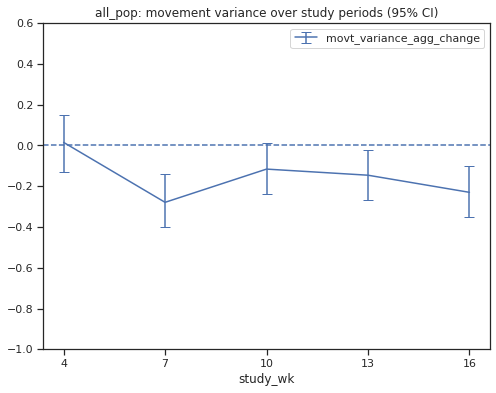

In [83]:
p = plot_over_time(['movt_variance_agg_change'], pop_df, "all_pop: movement variance over study periods (95% CI)")
p.ylim(-1,0.6)

In [72]:
symptomatic_df = build_time_corr_df(phq_corr[phq_corr['group_label'] == 'symptomatic'], 'phq_diff', agg_cols_change)

In [73]:
symptomatic_df[symptomatic_df['X'] == 'movt_variance_agg_change'][['X', 'Y', 'n', 'r', 'idx', 'p-unc','p-corr', 'p-adjust', 'CI95%']]

,X,Y,n,r,idx,p-unc,p-corr,p-adjust,CI95%
13,movt_variance_agg_change,phq_diff,137,0.009,4,0.915927,0.981350,fdr_bh,"[-0.16, 0.18]"
13,movt_variance_agg_change,phq_diff,137,-0.351,7,0.000025,0.000382,fdr_bh,"[-0.49, -0.2]"
13,movt_variance_agg_change,phq_diff,159,-0.144,10,0.071015,0.355074,fdr_bh,"[-0.29, 0.01]"
13,movt_variance_agg_change,phq_diff,160,-0.159,13,0.044878,0.232561,fdr_bh,"[-0.31, -0.0]"
13,movt_variance_agg_change,phq_diff,156,-0.260,16,0.001058,0.015865,fdr_bh,"[-0.4, -0.11]"


(-1, 0.6)

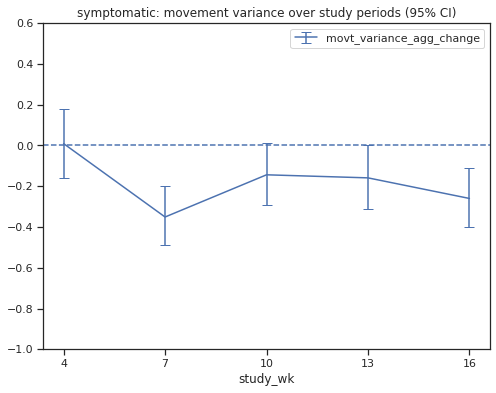

In [84]:
p = plot_over_time(['movt_variance_agg_change'], symptomatic_df, "symptomatic: movement variance over study periods (95% CI)")
p.ylim(-1,0.6)

## GAD

In [75]:
gad_df = build_time_corr_df(gad_spin_corr, 'gad_diff', agg_cols_change, study_wks=[7,10,13,16])

In [76]:
gad_df[gad_df['X'] == 'social_apps_agg_change']

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power,idx
2,social_apps_agg_change,gad_diff,pearson,two-sided,256,-0.131,"[-0.25, -0.01]",0.017,0.009,-0.132,0.036219,0.271644,fdr_bh,0.693,0.555,7
2,social_apps_agg_change,gad_diff,pearson,two-sided,257,0.048,"[-0.07, 0.17]",0.002,-0.006,0.048,0.444904,0.682782,fdr_bh,0.104,0.119,10
2,social_apps_agg_change,gad_diff,pearson,two-sided,258,-0.043,"[-0.16, 0.08]",0.002,-0.006,-0.043,0.489708,0.911332,fdr_bh,0.099,0.106,13
2,social_apps_agg_change,gad_diff,pearson,two-sided,258,0.049,"[-0.07, 0.17]",0.002,-0.005,0.049,0.428970,0.957820,fdr_bh,0.106,0.124,16


In [77]:
symptomatic_gad_df = build_time_corr_df(gad_spin_corr[gad_spin_corr['group_label'] == 'symptomatic'], 'gad_diff', agg_cols_change, study_wks=[7,10,13,16])

In [78]:
symptomatic_gad_df[symptomatic_gad_df['X'] == 'social_apps_agg_change']

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,p-corr,p-adjust,BF10,power,idx
2,social_apps_agg_change,gad_diff,pearson,two-sided,178,-0.163,"[-0.3, -0.02]",0.027,0.016,-0.164,0.029325,0.219939,fdr_bh,0.988,0.590,7
2,social_apps_agg_change,gad_diff,pearson,two-sided,179,0.023,"[-0.12, 0.17]",0.001,-0.011,0.023,0.763970,0.939167,fdr_bh,0.098,0.060,10
2,social_apps_agg_change,gad_diff,pearson,two-sided,181,-0.150,"[-0.29, -0.0]",0.022,0.012,-0.151,0.043923,0.329425,fdr_bh,0.697,0.524,13
2,social_apps_agg_change,gad_diff,pearson,two-sided,181,0.032,"[-0.11, 0.18]",0.001,-0.010,0.032,0.671368,0.896936,fdr_bh,0.102,0.071,16


(-0.4, 1)

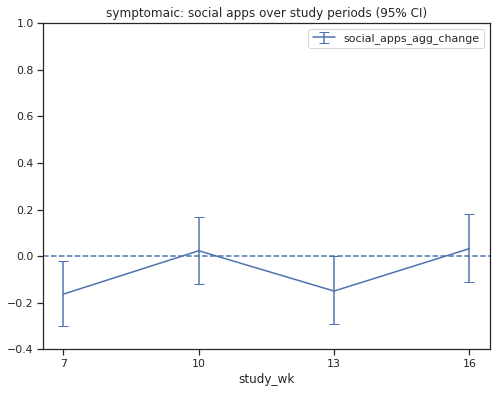

In [87]:
p = plot_over_time(['social_apps_agg_change'], symptomatic_gad_df, "symptomaic: social apps over study periods (95% CI)", study_wks=[7,10,13,16])
p.ylim(-0.4,1)